<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/DL_Models_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
#@title Specify parameters before running


SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  10#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  512#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = True #@param {type:"boolean"}


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

%matplotlib inline

import nltk
nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

#**Processing data**

Use the given datasets in our GitHub to load the data

In [120]:
  ## Uncomment each line to load Normal data

# Synthetic sendmail csv_file = ['bounce-1.int', 'bounce.int', 'bounce-2.int', 'plus.int', 'queue.int', 'sendmail.daemon.int', 'sendmail.log.int']; DATA = 'Synthetic Sendmail'; DATA_I='Synthetic_Sendmail'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/plus.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/queue.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.daemon.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.log.int'

# LIVE LPR csv_file = ['lpr-normal-10.txt', 'lpr-normal-11.txt']; DATA = 'Live Lpr'; DATA_I='Live-Lpr' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-11.txt'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-10.txt'

# MIT live lpr csv_file = [ 'mit-lpr-mar.txt']; DATA = 'MIT Live Lpr'; DATA_I='MIT-Lpr' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/mit-lpr-mar.txt'

# LOGIN and PS csv_file = [ 'login-normal.txt', 'ps-normal.txt']; DATA = 'Login and Ps'; DATA_I ="Login-and-Ps"
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/login-normal.txt'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/ps-normal.txt'

# INETD csv_file = [ 'inetd-live-unm.int']; DATA = 'Inetd';DATA_I ="Inetd" 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/inetd-live-unm.int'

# STIDE 
csv_file = [ 'stide-normal-500k.txt']; DATA = 'Stide';DATA_I ='Stide' 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/stide-normal-500k.txt'

# Live Named  ==> Best result csv_file = [ 'normal-named-live-2k.txt']; DATA = 'Live Named';DATA_I ='Live-Named' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/normal-named-live-2k.txt'

# Xlock csv_file = [ 'normal-xlock.txt']; DATA = 'Xlock';DATA_I='Xlock' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/normal-xlock.txt'

# Synthetic Ftp csv_file = [ 'nonself1.int','nonself2.int']; DATA = 'Synthetic Ftp'; DATA_I='Synthetic-Ftp'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself2.int'

# Synthetic lpr csv_file = ['syn.int']; DATA = 'Synthetic Lpr';DATA_I='Synthetic-Lpr'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/syn.int'

# Concat a list of files into normal df
list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep='\t', header=None, engine='python'))
df = pd.concat(list_of_dataframes)

# Check number of columns, if > 2, then drop the excess
if len(df.columns) > 2:
    df=df.drop(labels=None, axis=1, columns = [2,3])
df =df.rename(columns= {0:"PID", 1:"Syscall"})

print('Normal data size:', df.shape)


  ## Uncomment each line to load Intrusion data:

# Synthetic sendmail csv_file = ['sm-10763.int', 'fwd-loops-1.int', 'fwd-loops-2.int', 'fwd-loops-3.int', 'fwd-loops-4.int', 'fwd-loops-5.int','sm-280.int', 'sm-314.int','sm-10801.int', 'sm-10814.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-3.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-4.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-5.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10763.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-280.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-314.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10801.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10814.int'

# LIVE LPR csv_file =['exploit-unm.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Intrusion/exploit-unm.int'

# MIT live lpr csv_file = [ 'exploit-ai.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/exploit-ai.int'

# LOGIN and PS csv_file = [ 'login-homegrown.int','ps-homegrown.int','login-recovered.int','ps-recovered.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-homegrown.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-homegrown.int'

# INETD csv_file = [ 'inetd-intrusion.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/intrusion/inetd-intrusion.int'

# STIDE 
csv_file = [ 'stide-intrusion'] 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/intrusion/stide-intrusion'

# Live Named  ==> Best Result csv_file = [ 'exploit-1.int','exploit-2.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-2.int'

# Xlock csv_file = [ 'nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int', 'nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int'

# Synthetic Ftp csv_file = [ 'exploit2.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/intrusion/exploit2.int'

# Synthetic Lpr csv_file = [ 'exploit-unm.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/intrusion/exploit-unm.int'

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
intrusiondf = pd.concat(list_of_dataframes)

if len(intrusiondf.columns) > 2:
    intrusiondf = intrusiondf.drop(labels=None, axis=1, columns = [2,3])
intrusiondf = intrusiondf.rename(columns= {0:"PID", 1:"Syscall"})

print('intrusion data size: ', intrusiondf.shape)

print('Normal:',df.head(3))
#print(df['PID'].value_counts())
print('Intrusion:',intrusiondf.head())

--2021-11-10 02:17:54--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/stide-normal-500k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4048353 (3.9M) [text/plain]
Saving to: ‘stide-normal-500k.txt.1’

stide-normal-500k.t 100%[===================>]   3.86M  --.-KB/s    in 0.07s   

2021-11-10 02:17:54 (54.3 MB/s) - ‘stide-normal-500k.txt.1’ saved [4048353/4048353]

Normal data size: (499722, 2)
--2021-11-10 02:17:57--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/intrusion/stide-intrusion
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.11

**Change to covert all syscall of 1 PID into a data record. Pasrse each data record to a length of 10 or 15, clean frequent records.**

In [121]:
print('Number of unique PID in normal data:', len(df['PID'].value_counts()))
df

Number of unique PID in normal data: 279


,PID,Syscall
0,405,90
1,405,125
2,405,125
3,405,106
4,405,5
...,...,...
499717,20010,4
499718,20010,4
499719,20010,4
499720,20010,4


In [122]:
print('Number of unique PID in intrusion data:', len(intrusiondf['PID'].value_counts()))
intrusiondf

Number of unique PID in intrusion data: 105


,PID,Syscall
0,930,90
1,930,125
2,930,125
3,930,106
4,930,5
...,...,...
205930,1202,45
205931,1202,45
205932,1202,45
205933,1202,45


**Create syscall sequence per pid**

In [123]:
# This function groups data by PID, so the sequences appear by PID instead of by order, in case it was interrupted by other PID
## It returns a dict with PID as key and syscall seq as item
def group_syscalls_by_pid (data):
  seq_per_pid = {}
  for p in data['PID'].unique():
    filt = data['PID'] == p
    seq = data.loc[filt]['Syscall'].values.astype(str)
    seq_per_pid[p] = ' '.join(seq)
  return seq_per_pid

# Group normal df by PID and drop PID column
normal_seq_per_pid = group_syscalls_by_pid(df)
print('Number of unique PID in normal:', len(normal_seq_per_pid))
#print('Normal PIDs and its sequences: ',normal_seq_per_pid)

# Do the same thing to intrusion PID
intrusion_seq_per_pid = group_syscalls_by_pid(intrusiondf)
print('Number of unique PID in intrusion:', len(intrusion_seq_per_pid))
#print('Intrusion PIDs and its sequences: ', intrusion_seq_per_pid)

Number of unique PID in normal: 279
Number of unique PID in intrusion: 105


In [124]:
# Drop a sequence if its total len is less than 3
def remove_small_seq(pid_seq_dict):
  removed_pid = []
  for pid in pid_seq_dict:
    seq_list = pid_seq_dict[pid].split()
    if len(seq_list) < 3:
      print('Remove PID %d which only has %d syscals in its sequence: %s' % (pid, len(seq_list), pid_seq_dict[pid]))
      removed_pid.append(pid)

  [pid_seq_dict.pop(pid) for pid in removed_pid]
  return pid_seq_dict

# Clean small intrusion sequences
print('Clean small normal seq: \nNum PID in Normal before:', len(normal_seq_per_pid))
normal_seq_per_pid = remove_small_seq(normal_seq_per_pid)
print('Num PID in Normal after:', len(normal_seq_per_pid))

# Clean small intrusion sequences
print('\n\nClean small intrusion seq: \nNum PID in Intrusion before:', len(intrusion_seq_per_pid))
intrusion_seq_per_pid = remove_small_seq(intrusion_seq_per_pid)
print('Num PID in Intrusion after:', len(intrusion_seq_per_pid))

Clean small normal seq: 
Num PID in Normal before: 279
Num PID in Normal after: 279


Clean small intrusion seq: 
Num PID in Intrusion before: 105
Num PID in Intrusion after: 105


## **Data Parsing**

In [125]:
## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid:
    token = word_tokenize(seq_per_pid[p])  # Tokenize the string of sequence

    # Parse the sequence into length of 15
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW, pad_right=True, right_pad_symbol=-1)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(normal_seq_per_pid)

normal

,0,1,2,3,4,5,6,7,8,9
0,90,125,125,106,5,90,6,5,3,90
1,125,125,106,5,90,6,5,3,90,90
2,125,106,5,90,6,5,3,90,90,90
3,106,5,90,6,5,3,90,90,90,6
4,5,90,6,5,3,90,90,90,6,125
...,...,...,...,...,...,...,...,...,...,...
1156,4,4,4,4,4,-1,-1,-1,-1,-1
1157,4,4,4,4,-1,-1,-1,-1,-1,-1
1158,4,4,4,-1,-1,-1,-1,-1,-1,-1
1159,4,4,-1,-1,-1,-1,-1,-1,-1,-1


In [126]:
print('Parsing Intrusion')
intrusion = parse_seq(intrusion_seq_per_pid)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9
0,90,125,125,106,5,90,6,5,3,90
1,125,125,106,5,90,6,5,3,90,90
2,125,106,5,90,6,5,3,90,90,90
3,106,5,90,6,5,3,90,90,90,6
4,5,90,6,5,3,90,90,90,6,125
...,...,...,...,...,...,...,...,...,...,...
21,45,45,45,45,45,-1,-1,-1,-1,-1
22,45,45,45,45,-1,-1,-1,-1,-1,-1
23,45,45,45,-1,-1,-1,-1,-1,-1,-1
24,45,45,-1,-1,-1,-1,-1,-1,-1,-1


Start tokenizing system calls into 6-grams

 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df



In [127]:
## Get % of duplicates in both datasets

def clean_data (normal, intrusion):
  # Convert normal df to set, and intrusion df to set
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )

  # Only remove intrusion sequences that exist in normal set because these sequences are just general actions which should not be labelled intrusion
  c_intrusion = intrusion_set - normal_set
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)

  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' CLEAN Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

if CLEAN:
  normal, intrusion = clean_data(normal, intrusion)

List sz vs. Set sz of normal sequences: 499722 vs. 373
List sz vs. Set sz of intrusion sequences: 205935 vs. 315
After cleaning: 
Normal sz: 373  CLEAN Intrusion sz: 113


In [128]:
normal

,0,1,2,3,4,5,6,7,8,9
0,45,45,45,45,45,45,45,45,19,6
1,4,4,4,4,4,4,45,45,5,108
2,45,45,45,45,45,45,19,6,91,108
3,4,45,4,3,5,108,90,4,4,4
4,45,45,45,45,45,45,45,45,45,45
...,...,...,...,...,...,...,...,...,...,...
368,4,4,4,4,4,4,108,90,3,4
369,4,4,4,4,45,45,5,108,90,3
370,4,4,4,4,4,4,4,-1,-1,-1
371,4,4,4,4,4,4,45,45,45,45


In [129]:
intrusion

,0,1,2,3,4,5,6,7,8,9
0,45,45,45,45,45,45,45,45,19,6
1,4,4,4,4,4,4,45,45,5,108
2,45,45,45,45,45,45,19,6,91,108
3,90,3,45,45,45,19,6,91,108,90
4,19,6,91,108,90,3,4,4,45,4
...,...,...,...,...,...,...,...,...,...,...
310,4,4,4,4,4,4,108,90,3,4
311,4,4,4,4,45,45,5,108,90,3
312,4,4,4,4,4,119,4,4,4,4
313,4,4,4,4,4,4,4,4,119,4


## **Histogram of Processed Data**

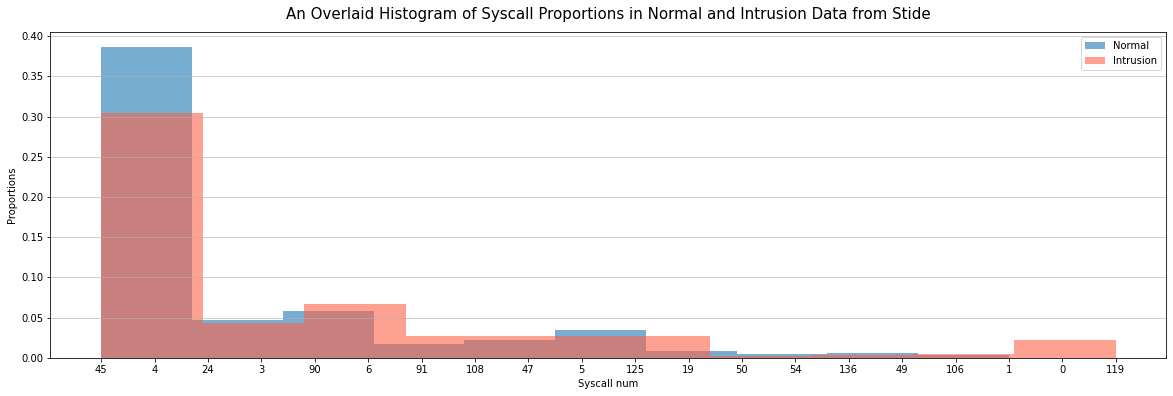

In [130]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
#plt.xticks(np.arange(0,200,10))
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)
plt.show()

**Labeling Sequences**

In [131]:
# Intrusion sequences is labeled 1. Rename columns of the dataframe
intrusion['Label'] = 1
print(intrusion.head(5), '\n')

    0   1   2    3   4   5   6   7    8    9  Label
0  45  45  45   45  45  45  45  45   19    6      1
1   4   4   4    4   4   4  45  45    5  108      1
2  45  45  45   45  45  45  19   6   91  108      1
3  90   3  45   45  45  19   6  91  108   90      1
4  19   6  91  108  90   3   4   4   45    4      1 



In [132]:
# Normal sequences is labeled 0. Rename columns of the dataframe
normal['Label'] = 0
print(normal.head(5), '\n')

print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))

    0   1   2   3   4    5   6   7   8    9  Label
0  45  45  45  45  45   45  45  45  19    6      0
1   4   4   4   4   4    4  45  45   5  108      0
2  45  45  45  45  45   45  19   6  91  108      0
3   4  45   4   3   5  108  90   4   4    4      0
4  45  45  45  45  45   45  45  45  45   45      0 

Normal len: 373 
Intrusion len: 315


## **Partition Training and Testing dataset 70/30**

If there is not enough data from either class, bootstrap to generate more data and create a balanced sample

In [133]:
# combine normal and intrusion data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (688, 11)
Train sz: 481 481
Train set: Intrusion vs. Normal cases 223 258
Test sz: 207 207
Test set: Intrusion vs. Normal cases 92 115


In [134]:
# Bootstrap training data

## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train

if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9
0,45,45,3,45,19,6,91,108,90,3
1,45,136,49,24,47,50,5,4,4,4
2,90,6,125,91,125,125,125,125,125,125
3,3,45,45,45,45,45,3,45,19,6
4,90,54,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...
511,45,45,45,3,45,45,45,45,45,19
512,4,108,90,54,4,4,4,4,4,4
513,45,45,45,45,45,45,45,1,-1,-1
514,45,3,45,45,45,45,45,45,19,6


In [135]:
y_train

0      0
1      0
2      0
3      1
4      0
      ..
511    1
512    0
513    0
514    1
515    0
Name: Label, Length: 516, dtype: int64

In [136]:
x_test

,0,1,2,3,4,5,6,7,8,9
0,4,4,4,4,4,45,4,4,4,4
1,90,90,90,6,125,5,3,90,90,90
2,45,45,3,45,45,45,45,45,45,45
3,125,125,45,45,45,45,45,45,45,45
4,6,91,108,90,3,45,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...
202,45,45,45,136,49,24,47,50,5,4
203,19,6,91,108,90,3,4,4,4,4
204,45,45,1,-1,-1,-1,-1,-1,-1,-1
205,3,45,19,6,91,108,90,3,4,4



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [137]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)

In [138]:
# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  try:
    plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
    plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
    plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
    plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
    plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
    plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
    plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
    plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  except:
    print('only performances of BERT and GPT are available')

  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **BERT**


In [139]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [140]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [141]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts) 

train_labels = tuple(y_train.tolist())
test_labels = tuple(y_test.tolist())

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(516, 516, 207, 207)

In [142]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

['4', '6', '91', '4', '4', '4', '4', '4', '4', '45']

In [143]:
# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )       

Number of Training Sequences: 516 
Number of Testing Sequences: 207


In [144]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((516, 20), (207, 20))

In [145]:
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((516,), (207,), 0.5, 0.4444444444444444)

In [146]:
# To mask the paddings
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [147]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [149]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

**Fine Tune BERT**

In [150]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

RuntimeError: ignored

**Evaluate on Testing Set**

In [ ]:
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

# Convert to tensro for maks
test_masks_tensor = torch.tensor(test_masks)


# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Defile test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [ ]:
bert_clf.eval() # Define eval
bert_predicted = [] # To Store predicted result
all_logits = [] # Actual output that is between 0 to 1 is stored here

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print_performance('BERT',test_y, bert_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
BERT_test = {}
BERT_test['fpr'], BERT_test['tpr'], thresh = roc_curve(test_y, bert_predicted)
BERT_test['auc'] = roc_auc_score(test_y, bert_predicted)

In [ ]:
#BERT_test = {'fpr': 0.8, 'auc': 0.9}

In [ ]:
# Save BERT performance measures to a file
def write_to_file (filename, varname, model_name):
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()

write_to_file("stide-pm.txt", BERT_test, 'BERT')

# **GPT-2**

In [ ]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [ ]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)

In [ ]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

In [ ]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [ ]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [ ]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

In [ ]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

**Evaluate on Testing Set**

In [ ]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)


In [ ]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

In [ ]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 

In [ ]:
write_to_file("stide-pm.txt", GPT_test, 'GPT')

In [ ]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + ".txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(BERT_test, 'BERT')
write_to_file(GPT_test, 'GPT')